# Pixel clustering notebook

In [ ]:
# import required packages
from datetime import datetime as dt
import os
import subprocess

import feather
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr

from ark.analysis import visualize
from ark.phenotyping import som_utils
from ark.utils import data_utils, io_utils, load_utils, plot_utils

### Set file paths and parameters

* `base_dir`: the path to all of your imaging data. Should contain a directory for your images, segmentations, and cell table (generated from Segment_Image_Data.ipynb).
* `tiff_dir`: the path to the directory containing your imaging data
* `segmentation_dir`: the path to the directory containing your segmentations (generated from Segment_Image_Data.ipynb)
* `preprocessed_dir`: the name of the directory to save the preprocessed pixel data (placed in base_dir)
* `subsetted_dir`: the name of the directory to save the subsetted pixel data (placed in base_dir)
* `MIBItiff`: if the images in tiff_dir are mibitiff or not
* `mibitiff_suffix` (required if MIBItiff is True): the file suffix all mibitiff images contain

In [ ]:
base_dir = "../data/granulomaCohort_allData"
tiff_dir = os.path.join(base_dir, "TIFs")
segmentation_dir = "../data/granulomaCohort_allData"
preprocessed_dir = 'pixel_mat_preprocessed'
subsetted_dir = 'pixel_mat_subsetted'
MIBItiff = False
mibitiff_suffix = '-MassCorrected-Filtered.tiff'

* `fovs` (optional): set a specific set of fovs to load, default loads all the fovs in tiff_dir

In [ ]:
# either get all fovs in the folder...
if MIBItiff:
    fovs = io_utils.list_files(tiff_dir, substrs=MIBItiff_suffix)
else:
    fovs = io_utils.list_folders(tiff_dir)

# ... or optionally, select a specific set of fovs manually
# fovs = ["fov14"]

# we'll need to store fovs for use in example_cell_clustering.ipynb
%store fovs

### Preprocess

* `channels`: set a subset to run pixel clustering over

In [ ]:
channels = ["CD45", "SMA", "Vimentin", "CD31", "Keratin-pan", "E-cadherin", "MastChyTry",
            "MPO", "CD20", "CD3", "CD14", "HLA-DR-DQ-DP", "Foxp3", "CD16", "CD11c", "CD206",
            "CD11b", "CD68", "CD163", "CD209"]

# we'll need to store channels for use in example_cell_clustering.ipynb
%store channels

Set the following arguments

* `blur_factor`: the sigma to use for the Gaussian filter when running the Gaussian blur. Higher values are more aggressive in removing noise.
* `subset_proportion`: the percentage of pixels to take from each fov. Sampling is random.

In [ ]:
blur_factor = 2
subset_proportion = 0.1

In [ ]:
# run pixel data preprocessing
som_utils.create_pixel_matrix(
    fovs,
    channels,
    base_dir,
    tiff_dir,
    segmentation_dir,
    pre_dir=preprocessed_dir,
    sub_dir=subsetted_dir,
    is_mibitiff=MIBItiff,
    blur_factor=blur_factor,
    subset_proportion=subset_proportion
)

### Train pixel SOM

Set a prefix to be applied to all data directories/files created by pixel and cell clustering. If the prefix is not set, a default of the datetime at the start of the run is used. The following data directories/files will be created for pixel clustering:

* `{cluster_prefix}_pixel_clustered_dir`: directory to store pixel data with just the SOM cluster assignments
* `{cluster_prefix}_pixel_consensus_dir`: directory to store pixel data with the SOM and consensus cluster assignments
* `{cluster_prefix}_pixel_weights_name`: file name to place the pixel SOM weights

In [ ]:
# explicitly set cluster_prefix to override datetime default
cluster_prefix = None

if cluster_prefix is None:
    cluster_prefix = dt.now().strftime('%Y-%m-%dT%H:%M:%S')
    
# define the pixel SOM cluster, consensus cluster paths, and pixel SOM weights paths using specified prefix
pixel_clustered_dir = '%s_pixel_mat_clustered' % cluster_prefix
pixel_consensus_dir = '%s_pixel_mat_consensus' % cluster_prefix
pixel_weights_name = '%s_pixel_weights.feather' % cluster_prefix

# we'll need to store pixel_consensus_dir for usage in example_cell_clustering.ipynb
%store pixel_consensus_dir

For a full set of parameters you can customize for train_pixel_som, please consult: <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.train_pixel_som>pixel training docs</a>

In [ ]:
# create the pixel-level SOM weights
som_utils.train_pixel_som(
    fovs,
    channels,
    base_dir,
    sub_dir=subsetted_dir,
    weights_name=pixel_weights_name,
    num_passes=10
)

### Assign pixel SOM clusters

In [ ]:
# use pixel SOM weights to assign pixel clusters
som_utils.cluster_pixels(
    fovs,
    base_dir,
    pre_dir=preprocessed_dir,
    weights_name=pixel_weights_name,
    cluster_dir=pixel_clustered_dir
)

### Visualize number of pixels per SOM cluster

In [ ]:
# compute the number of pixels per SOM cluster
pixel_som_counts = som_utils.compute_pixel_cluster_counts(
    fovs,
    channels,
    base_dir,
    data_dir=pixel_clustered_dir,
    pixel_cluster_col='cluster'
)

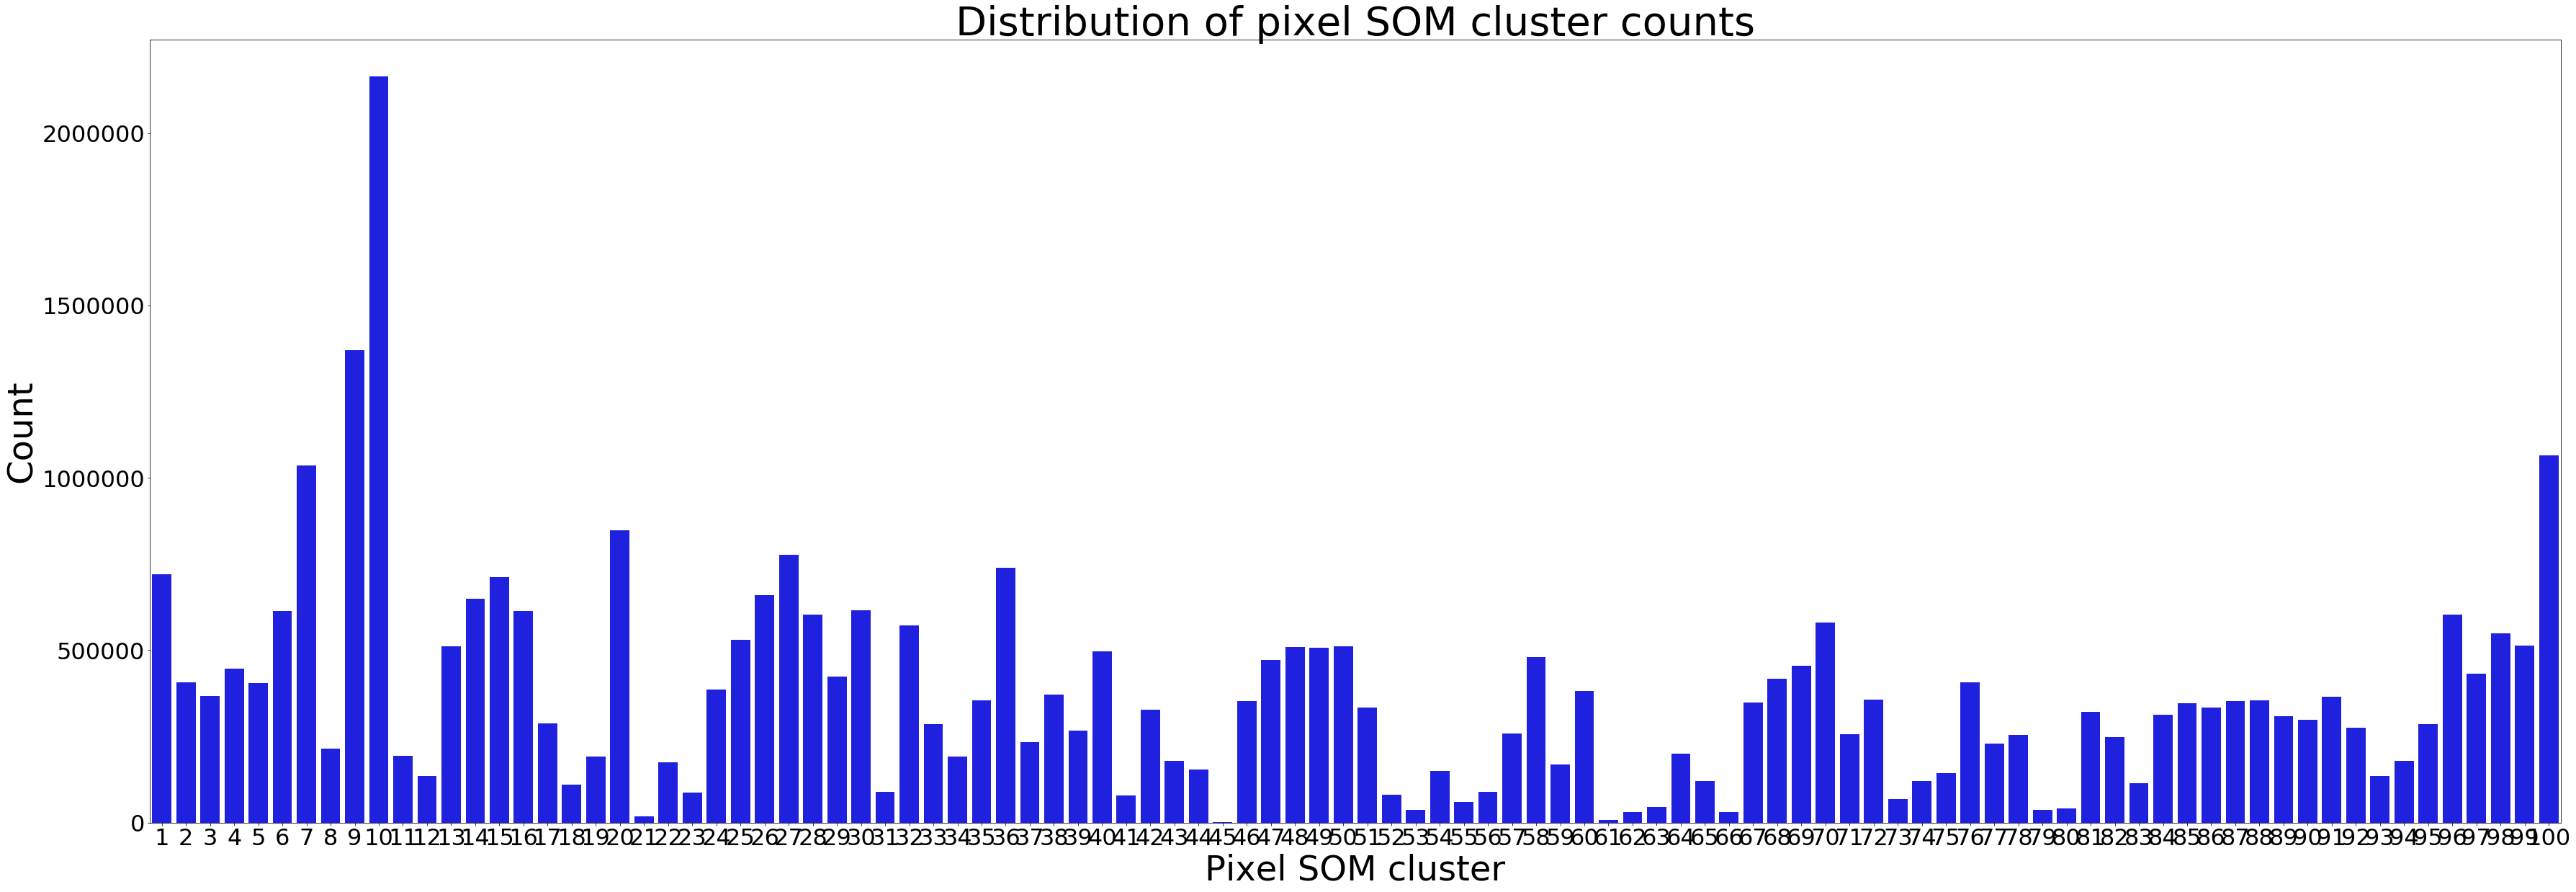

In [11]:
# visualize the pixel counts per SOM cluster in a barchart
_ = plt.figure(figsize=(60, 20))
_ = sns.barplot(x=pixel_som_counts['cluster'], y=pixel_som_counts['count'], palette=['#0000FF' for i in range(pixel_som_counts.shape[0])])
_ = plt.title('Distribution of pixel SOM cluster counts', fontsize=56)
_ = plt.xlabel('Pixel SOM cluster', fontsize=48)
_ = plt.ylabel('Count', fontsize=48)
_ = plt.xticks(fontsize=32)
_ = plt.yticks(fontsize=32)

### Visualize the pixel SOM cluster average over channels (z-scored)

* The pixel channel average computation will also be used in `example_cell_clustering.ipynb` and for interactive reclustering
* Averages are saved as `pixel_cluster_channel_avg_cluster.feather`

In [ ]:
# compute average channel expression for each pixel som cluster
pixel_cluster_channel_avg_cluster = som_utils.compute_pixel_cluster_channel_avg(
    fovs, channels, base_dir, 'cluster', pixel_clustered_dir
)

# save pixel_cluster_channel_avg_cluster
feather.write_dataframe(
    pixel_cluster_channel_avg_cluster, os.path.join(base_dir, 'pixel_cluster_channel_avg_cluster.feather')
)

# store pixel_cluster_channel_avg_cluster for use in example_cell_clustering.ipynb
%store pixel_cluster_channel_avg_cluster

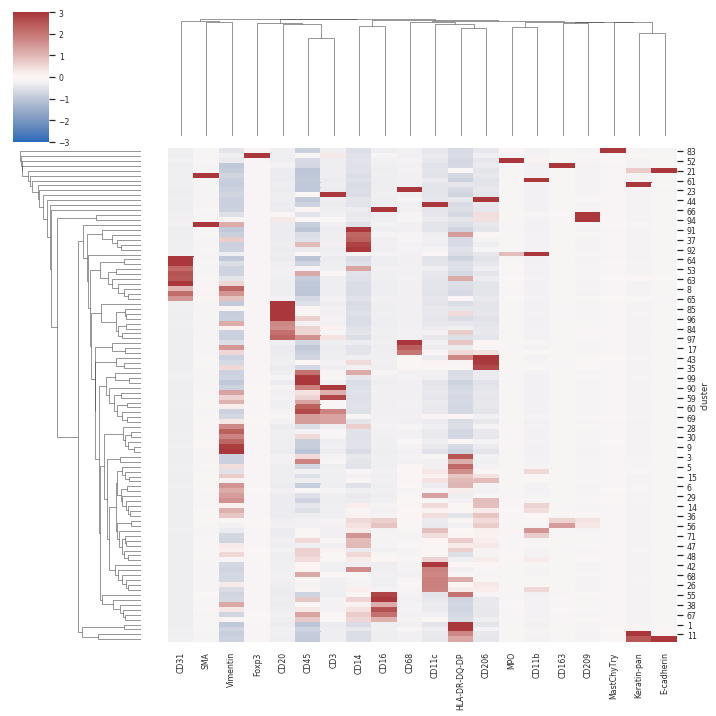

In [13]:
# visualize average channel expression for each pixel som cluster
visualize.draw_heatmap(
    stats.zscore(pixel_cluster_channel_avg_cluster[channels]),
    pixel_cluster_channel_avg_cluster['cluster'],
    channels,
    center_val=0,
    min_val=-3,
    max_val=3,
    cbar_ticks=np.arange(-3, 4),
    colormap='vlag'
)

### Run pixel consensus clustering

For a full set of parameters you can customize for pixel_consensus_cluster, please consult: https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.pixel_consensus_cluster

In [ ]:
# run hierarchical clustering based on pixel SOM cluster assignments
som_utils.pixel_consensus_cluster(
    fovs,
    channels,
    base_dir,
    cluster_dir=pixel_clustered_dir,
    consensus_dir=pixel_consensus_dir
)

### Visualize the number of pixels per meta cluster

In [ ]:
# compute the number of pixels per SOM cluster
pixel_meta_counts = som_utils.compute_pixel_cluster_counts(
    fovs,
    channels,
    base_dir,
    data_dir=pixel_consensus_dir,
    pixel_cluster_col='hCluster_cap'
)

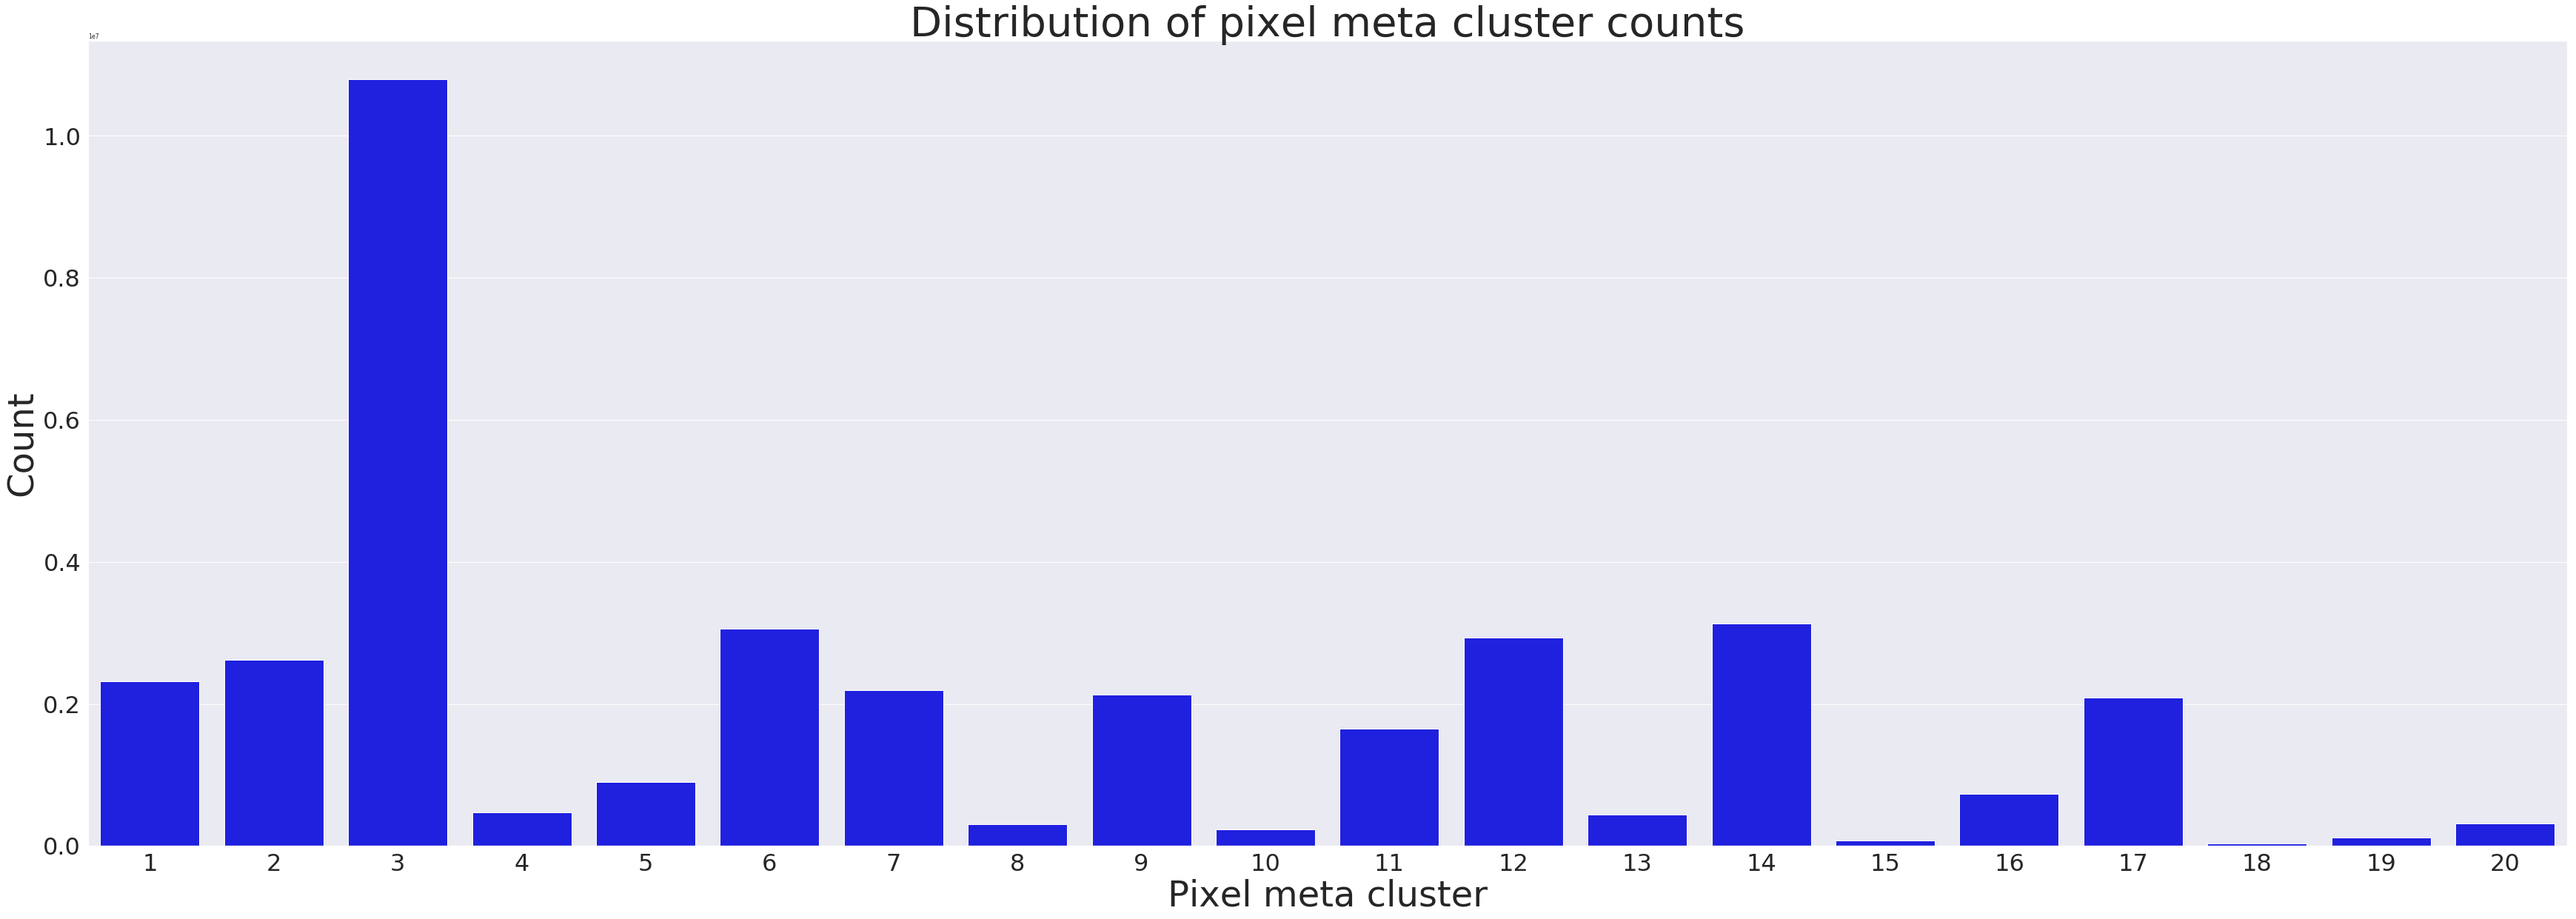

In [16]:
# visualize the pixel counts per SOM cluster in a barchart
_ = plt.figure(figsize=(60, 20))
_ = sns.barplot(x=pixel_meta_counts['hCluster_cap'], y=pixel_meta_counts['count'], palette=['#0000FF' for i in range(pixel_meta_counts.shape[0])])
_ = plt.title('Distribution of pixel meta cluster counts', fontsize=56)
_ = plt.xlabel('Pixel meta cluster', fontsize=48)
_ = plt.ylabel('Count', fontsize=48)
_ = plt.xticks(fontsize=32)
_ = plt.yticks(fontsize=32)

### Visualize the pixel meta cluster average heatmap over channels (z-scored)

* The pixel channel average computation will also be used in `example_cell_clustering.ipynb` and for interactive reclustering
* Averages are saved as `pixel_cluster_channel_avg_hCluster_cap.feather`

In [ ]:
# compute average channel expression for each pixel meta cluster
pixel_cluster_channel_avg_hCluster_cap = som_utils.compute_pixel_cluster_channel_avg(
    fovs, channels, base_dir, 'hCluster_cap', pixel_consensus_dir
)

# save pixel_cluster_channel_avg_hCluster_cap
feather.write_dataframe(
    pixel_cluster_channel_avg_hCluster_cap, os.path.join(base_dir, 'pixel_cluster_channel_avg_hCluster_cap.feather')
)

# store pixel_cluster_channel_avg_hCluster_cap for use in example_cell_clustering.ipynb
%store pixel_cluster_channel_avg_hCluster_cap

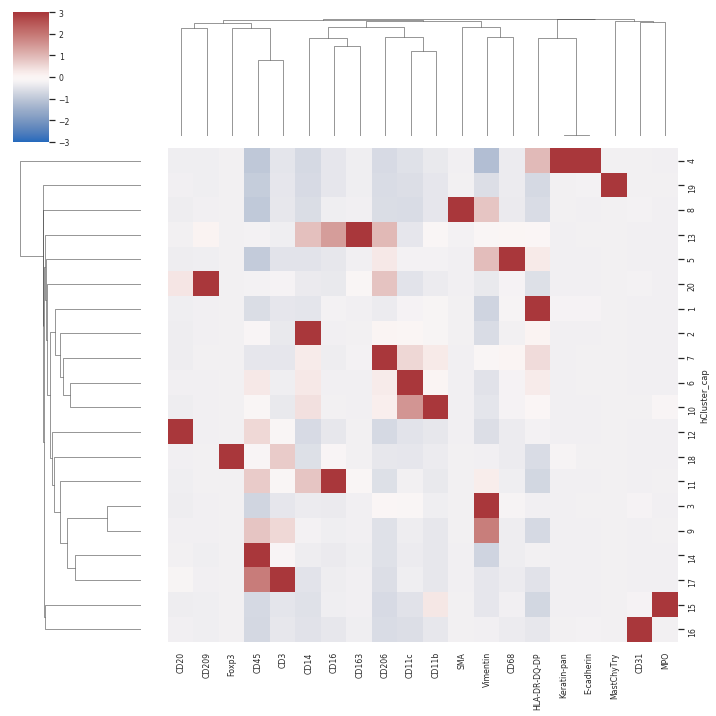

In [18]:
# visualize average channel expression for each pixel meta cluster
visualize.draw_heatmap(
    stats.zscore(pixel_cluster_channel_avg_hCluster_cap[channels]),
    pixel_cluster_channel_avg_hCluster_cap['hCluster_cap'],
    channels,
    center_val=0,
    min_val=-3,
    max_val=3,
    cbar_ticks=np.arange(-3, 4),
    colormap='vlag'
)

### Visualize pixel cluster overlay

In [ ]:
# select fovs to display
pixel_fovs = ['fov6', 'fov7']

In [ ]:
# generate the pixel cluster masks for each fov in pixel_fovs
pixel_cluster_masks = data_utils.generate_pixel_cluster_mask(
    fovs,
    base_dir,
    segmentation_dir,
    pixel_consensus_dir=pixel_consensus_dir,
    cluster_col='hCluster_cap'
)

* `save_pixel_masks`: replace with True if you want to save, files will be written as `{fov_name}_pixel_mask.tiff` in `base_dir`

In [ ]:
save_pixel_masks = False

if save_pixel_masks:
    data_utils.save_fov_images(
        pixel_fovs,
        base_dir,
        pixel_cluster_masks,
        name_suffix='_pixel_mask'
    )

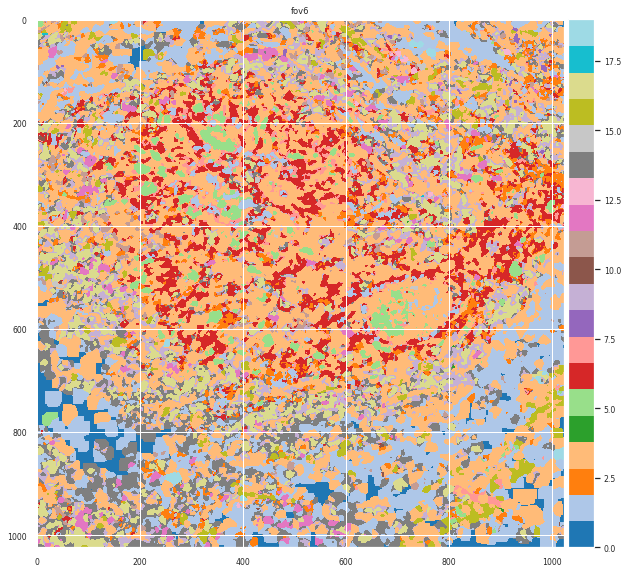

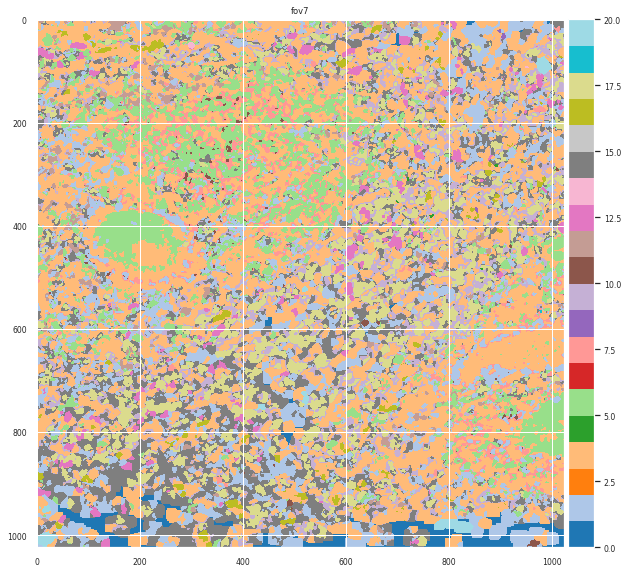

In [22]:
plot_utils.plot_clustering_result(
    pixel_cluster_masks,
    pixel_fovs
)